# Step1 Create the MIDI file from notes
### use Magenta


https://github.com/magenta/magenta

# MelodyRNN

 1.1 Set Up the Environment

*   Install dependencies
*   Import ctypes.util
*   Import files
*   Import magenta
*   Import note_seq
*   Import tensorflow








In [20]:
#@title Set Up the Environment
import glob

print('Installing dependencies...')
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -qU pyfluidsynth pretty_midi
!pip install -qU magenta


import ctypes.util
orig_ctypes_util_find_library = ctypes.util.find_library
def proxy_find_library(lib):
  if lib == 'fluidsynth':
    return 'libfluidsynth.so.1'
  else:
    return orig_ctypes_util_find_library(lib)
ctypes.util.find_library = proxy_find_library

print('Importing libraries and defining some helper functions...')
from google.colab import files
import magenta
import note_seq
import tensorflow
import magenta.music as mm
from magenta.models.music_vae import configs
from magenta.models.music_vae.trained_model import TrainedModel
import numpy as np
import os
import tensorflow.compat.v1 as tf


tf.disable_v2_behavior()


def play(note_sequence):
  mm.play_sequence(note_sequence, synth=mm.fluidsynth)
def interpolate(model, start_seq, end_seq, num_steps, max_length=32,
                assert_same_length=True, temperature=0.5,
                individual_duration=4.0):
  """Interpolates between a start and end sequence."""
  note_sequences = model.interpolate(
      start_seq, end_seq,num_steps=num_steps, length=max_length,
      temperature=temperature,
      assert_same_length=assert_same_length)

  print('Start Seq Reconstruction')
  play(note_sequences[0])
  print('End Seq Reconstruction')
  play(note_sequences[-1])
  print('Mean Sequence')
  play(note_sequences[num_steps // 2])
  print('Start -> End Interpolation')
  interp_seq = mm.sequences_lib.concatenate_sequences(
      note_sequences, [individual_duration] * len(note_sequences))
  play(interp_seq)
  mm.plot_sequence(interp_seq)
  return interp_seq if num_steps > 3 else note_sequences[num_steps // 2]

def download(note_sequence, filename):
  mm.sequence_proto_to_midi_file(note_sequence, filename)
  files.download(filename)

print('🎉 Done!')
print(magenta.__version__)
print(tensorflow.__version__)

Installing dependencies...
Importing libraries and defining some helper functions...
🎉 Done!
2.1.3
2.6.0


1.2 Create Note Sequence

In [21]:
#@title Input some notes
from note_seq.protobuf import music_pb2

print('Generating notes...')

demo_notes = music_pb2.NoteSequence()

# Add the notes to the sequence.
demo_notes.notes.add(pitch=62, start_time=0.0, end_time=0.75, velocity=80) #@param{}
demo_notes.notes.add(pitch=62, start_time=0.75, end_time=1.25, velocity=80) #@param{}
demo_notes.notes.add(pitch=66, start_time=1.5, end_time=1.75, velocity=80) #@param{}
demo_notes.notes.add(pitch=65, start_time=1.75, end_time=2.0, velocity=80) #@param{}
demo_notes.notes.add(pitch=64, start_time=2.0, end_time=2.75, velocity=80) #@param{}
demo_notes.notes.add(pitch=62, start_time=2.75, end_time=3.25, velocity=80) #@param{}

demo_notes.notes.add(pitch=67, start_time=4.0, end_time=4.25, velocity=80) #@param{}
demo_notes.notes.add(pitch=69, start_time=4.25, end_time=4.5, velocity=80) #@param{}
demo_notes.notes.add(pitch=66, start_time=4.5, end_time=5.25, velocity=80) #@param{}
demo_notes.notes.add(pitch=67, start_time=5.25, end_time=5.75, velocity=80) #@param{}


demo_notes.notes.add(pitch=64, start_time=6.0, end_time=6.25, velocity=80) #@param{}
demo_notes.notes.add(pitch=66, start_time=6.25, end_time=6.5, velocity=80) #@param{}
demo_notes.notes.add(pitch=64, start_time=6.5, end_time=7.25, velocity=80) #@param{}
demo_notes.notes.add(pitch=62, start_time=7.25, end_time=7.75, velocity=80) #@param{}

demo_notes.total_time = 8 #@param{}

demo_notes.tempos.add(qpm=120) #@param{}

# This is a colab utility method that visualizes a NoteSequence.
note_seq.plot_sequence(demo_notes)

# This is a colab utility method that plays a NoteSequence.
note_seq.play_sequence(demo_notes,synth=note_seq.fluidsynth)



Generating notes...


1.3 Initialize RNN Model

In [22]:
#@title Initializing
print('Downloading model bundle...')
note_seq.notebook_utils.download_bundle('basic_rnn.mag', '/content/')

# Import dependencies.
from magenta.models.melody_rnn import melody_rnn_sequence_generator
from magenta.models.shared import sequence_generator_bundle
from note_seq.protobuf import generator_pb2
from note_seq.protobuf import music_pb2

# Initialize the model.
print("Initializing Melody RNN...")
bundle = sequence_generator_bundle.read_bundle_file('/content/basic_rnn.mag')
generator_map = melody_rnn_sequence_generator.get_generator_map()
melody_rnn = generator_map['basic_rnn'](checkpoint=None, bundle=bundle)
melody_rnn.initialize()

print('🎉 Done!')

Initializing Melody RNN...
'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from /tmp/tmprhucod2z/model.ckpt
🎉 Done!


1.4 Create a Melody from the Note Sequence

In [23]:
#@title Input steps and temprature
# Model options. Change these to get different generated sequences! 
print("Generating Melody...")
input_sequence = demo_notes 
num_steps = 256 #@param 
 # the higher the temperature the more random the sequence.
temperature = 1.1 #@param{type:"slider", min:0.1, max:2, step:0.1} 



# Set the start time to begin on the next step after the last note ends.
last_end_time = (max(n.end_time for n in input_sequence.notes)
                  if input_sequence.notes else 0)
qpm = input_sequence.tempos[0].qpm 
seconds_per_step = 60.0 / qpm / melody_rnn.steps_per_quarter
total_seconds = num_steps * seconds_per_step

generator_options = generator_pb2.GeneratorOptions()
generator_options.args['temperature'].float_value = temperature
generate_section = generator_options.generate_sections.add(
  start_time=last_end_time + seconds_per_step,
  end_time=total_seconds)

# Ask the model to continue the sequence.
sequence = melody_rnn.generate(input_sequence, generator_options)

note_seq.plot_sequence(sequence)
note_seq.play_sequence(sequence, synth=note_seq.fluidsynth)


Generating Melody...
INFO:tensorflow:Beam search yields sequence with log-likelihood: -251.830414 


1.5 Covert the sequence to midi file

In [24]:
#@title Converting
print("Converting the Sequence to MIDI...")
note_seq.sequence_proto_to_midi_file(sequence, 'RNN_output.mid') 

##Download the midi file
#files.download('demo_sample_output.mid')
print('🎉 Done!')

Converting the Sequence to MIDI...
🎉 Done!


# MusicVAE

In [ ]:
#@title Load the pre-trained models.

BASE_DIR = "gs://download.magenta.tensorflow.org/models/music_vae/colab2"
trio_models = {}
hierdec_trio_16bar_config = configs.CONFIG_MAP['hierdec-trio_16bar']
trio_models['hierdec_trio_16bar'] = TrainedModel(hierdec_trio_16bar_config, batch_size=4, checkpoint_dir_or_path=BASE_DIR + '/checkpoints/trio_16bar_hierdec.ckpt')

flat_trio_16bar_config = configs.CONFIG_MAP['flat-trio_16bar']
trio_models['baseline_flat_trio_16bar'] = TrainedModel(flat_trio_16bar_config, batch_size=4, checkpoint_dir_or_path=BASE_DIR + '/checkpoints/trio_16bar_flat.ckpt')
print('🎉 Done!')

INFO:tensorflow:Building MusicVAE model with BidirectionalLstmEncoder, HierarchicalLstmDecoder, and hparams:
{'max_seq_len': 256, 'z_size': 512, 'free_bits': 256, 'max_beta': 0.2, 'beta_rate': 0.0, 'batch_size': 4, 'grad_clip': 1.0, 'clip_mode': 'global_norm', 'grad_norm_clip_to_zero': 10000, 'learning_rate': 0.001, 'decay_rate': 0.9999, 'min_learning_rate': 1e-05, 'conditional': True, 'dec_rnn_size': [1024, 1024], 'enc_rnn_size': [2048, 2048], 'dropout_keep_prob': 1.0, 'sampling_schedule': 'constant', 'sampling_rate': 0.0, 'use_cudnn': False, 'residual_encoder': False, 'residual_decoder': False, 'control_preprocessing_rnn_size': [256]}
INFO:tensorflow:
Encoder Cells (bidirectional):
  units: [2048, 2048]

INFO:tensorflow:
Hierarchical Decoder:
  input length: 256
  level output lengths: [16, 16]

INFO:tensorflow:
Decoder Cells:
  units: [1024, 1024]

INFO:tensorflow:
Decoder Cells:
  units: [1024, 1024]

INFO:tensorflow:
Decoder Cells:
  units: [1024, 1024]



/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer_v1.py:1684: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Do not call `graph_parents`.
INFO:tensorflow:Restoring parameters from gs://download.magenta.tensorflow.org/models/music_vae/colab2/checkpoints/trio_16bar_hierdec.ckpt
INFO:tensorflow:Building MusicVAE model with BidirectionalLstmEncoder, MultiOutCategoricalLstmDecoder, and hparams:
{'max_seq_len': 256, 'z_size': 512, 'free_bits': 0.0, 'max_beta': 1.0, 'beta_rate': 0.0, 'batch_size': 4, 'grad_clip': 1.0, 'clip_mode': 'global_norm', 'grad_norm_clip_to_zero': 10000, 'learning_rate': 0.001, 'decay_rate': 0.9999, 'min_learning_rate': 1e-05, 'conditional': True, 'dec_rnn_size': [2048, 2048, 2048], 'enc_rnn_size': [2048, 2048], 'dropout_keep_prob': 1.0, 'sampling_schedule': 'constant', 'sampling_rate

In [ ]:
#@title Generate 2 samples from the selected model prior.
trio_sample_model = "hierdec_trio_16bar" #@param ["hierdec_trio_16bar", "baseline_flat_trio_16bar"]
temperature = 0.5 #@param {type:"slider", min:0.1, max:1.5, step:0.1}

trio_16_samples = trio_models[trio_sample_model].sample(n=2, length=256, temperature=temperature)
for ns in trio_16_samples:
  note_seq.plot_sequence(ns)
  play(ns)

In [ ]:
#@title Save the samples
input_trio_midi_data = trio_16_samples
print('🎉 Done!')

In [ ]:
#@title Compute the reconstructions and mean of the two trios, selected from the previous cell.
trio_interp_model = "hierdec_trio_16bar" #@param ["hierdec_trio_16bar", "baseline_flat_trio_16bar"]

start_trio = 0 #@param {type:"integer"}
end_trio = 1 #@param {type:"integer"}
start_trio = trio_16_samples[start_trio]
end_trio = trio_16_samples[end_trio]

temperature = 0.5 #@param {type:"slider", min:0.1, max:1.5, step:0.1}
trio_16bar_mean = interpolate(trio_models[trio_interp_model], start_trio, end_trio, num_steps=3, max_length=256, individual_duration=32, temperature=temperature)

Start Seq Reconstruction


End Seq Reconstruction


Mean Sequence


Start -> End Interpolation


In [ ]:
#@title Play the interpolating sequence
note_sequences = trio_models[trio_interp_model].interpolate(
      start_trio, end_trio,num_steps=3, length=256,
      temperature=0.5,
      assert_same_length=True)


interp_seq = mm.sequences_lib.concatenate_sequences(note_sequences, [32.0] * len(note_sequences))
play(interp_seq)


In [ ]:
#@title Covert the sequence to MIDI file
note_seq.sequence_proto_to_midi_file(interp_seq, 'interp_seq.mid') 

In [ ]:
#@title Download the MIDI file
files.download('interp_seq.mid')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title Install Mido
!pip install mido
from mido import MidiFile


In [ ]:
#@title Get the information of the MIDI file
mid = MidiFile('interp_seq.mid')
print(mid)

<midi file 'interp_seq.mid' type 1, 4 tracks, 1537 messages>


In [ ]:
#@title Show the tracks of the MIDI file
for track in mid.tracks:
  print(track)

<midi track '' 3 messages>
<midi track '' 404 messages>
<midi track '' 220 messages>
<midi track '' 910 messages>


In [ ]:
#@title Delete the last track
del mid.tracks[2]

In [ ]:
#@title Delete the second track
del mid.tracks[2]

In [ ]:
#@title Save the remained track as a new MIDI file
mid.save('lead.mid')

In [ ]:
#@title Download the new MIDI file
files.download('lead.mid')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title Show tracks of the new MIDI file
lead_mid=MidiFile('lead.mid')
for track in lead_mid.tracks:
  print(track)

<midi track '' 3 messages>
<midi track '' 404 messages>


# Step2 Generate the Lyrics

https://github.com/adigoryl/Styled-Lyrics-Generator-GPT2

2.1 Autenticate the google account

In [25]:
#@title Click RUN to authenticate google account.
from google.colab import auth
auth.authenticate_user()  # must authenticate


'''list all ids of files directly under folder folder_id'''
def folder_list(folder_id):
  from googleapiclient.discovery import build
  gdrive = build('drive', 'v3').files()
  res = gdrive.list(q="'%s' in parents" % folder_id).execute()
  return [f['id'] for f in res['files']]

'''download all files from a gdrive folder to current directory'''
def folder_download(folder_id):
  for fid in folder_list(folder_id):
    !gdown -q --id $fid

folder_id = "18PzSRxHcXvtJWzO3YwtsTXWDW7hhu06U"
folder_download(folder_id)
print('🎉 Done!')

🎉 Done!


2.2 Set Up the Environment.

In [26]:
#@title Click RUN to install and set up.
!pip install transformers==3.0.1

import logging
import argparse
import torch
import torch.nn.functional as F
import numpy as np

from transformers import GPT2Tokenizer, GPT2LMHeadModel
from tqdm import tqdm, trange

import utilities as U

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOAD_MODEL_DIR = "/content"

# Reload the model and the tokenizer
model = GPT2LMHeadModel.from_pretrained(LOAD_MODEL_DIR)
enc = GPT2Tokenizer.from_pretrained(LOAD_MODEL_DIR)
model.to(device)
model.eval()
print('🎉 Done!')

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at /content and are newly initialized: ['transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.6.attn.masked_bias', 'transformer.h.7.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.9.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🎉 Done!


2.3 Generate lyrics

In [27]:
#@title Set Conditions and click RUN to generated lyrics.
genre = "Rock" #@param ["None",'Pop',"Rap","Country","Rock","Reggae"]
artist = "Pink Floyd(Rock)" #@param ["None",'Gregory Isaacs (Reggae)', 'Maxi Priest (Reggae)', 'Genesis (Rock)', 'DMX (Rap)', 'Chris Lane (Country)', 'Michael Jackson (Pop)', 'Alabama (Country)', 'Deep Purple (Rock)', 'Pink Floyd(Rock)','André 3000 (Rap)', 'Janis Joplin (Rock)', 'Alison Krauss (Country)', 'Marty Stuart (Country)', 'Green Day (Rock)', 'Kiss (Rock)', 'Juice WRLD (Rap)', 'LANco (Country)', 'Whitney Houston (Pop)', 'Logic (Rap)', 'The Kinks (Rock)', 'Donald Glover & Danny Pudi (Rap)', '5 Seconds of Summer (Pop)', 'Bill Monroe (Country)', 'Pearl Jam (Rock)', 'David Bowie (Rock)', 'Iron Maiden (Rock)', 'Johnny Cash (Country)', 'Elton John (Pop)', 'Foo Fighters (Rock)', 'Gentleman (Reggae)', 'Jessi Colter (Country)', 'Natasha Bedingfield (Pop)', 'Missy Elliott (Rap)', 'Black Sabbath (Rock)', 'Roy Acuff (Country)', 'Justin Bieber (Pop)', 'Crystal Gayle (Country)', 'Greta Van Fleet (Rock)', 'Brett Young (Country)', 'The Weeknd (Pop)', 'Toby Keith (Country)', 'Slick Rick (Rap)', 'The Velvet Underground (Rock)', 'Queen (Rock)', 'Santana (Rock)', 'Dwight Yoakam (Country)', 'NF (Rap)', 'Buck Owens (Country)', 'Elvis Presley (Rock)', 'Big Shaq (Rap)', 'Childish Gambino (Rap)', 'Chuck Berry (Rock)', 'Scarface (Rap)', 'Eric Church (Country)', 'Daniel Powter (Pop)', 'Dr.\xa0Dre (Rap)', 'Buju Banton (Reggae)', 'James Blunt (Pop)', 'Steps (Pop)', 'Alton Ellis (Reggae)', 'Hank Williams (Country)', 'Michael Ray (Country)', 'Seal (Pop)', 'T-Pain (Pop)', 'Tom T. Hall (Country)', 'Ricky Martin (Pop)', 'Busta Rhymes (Rap)', 'Kesha (Pop)', 'Led Zeppelin (Rock)', 'The Moody Blues (Rock)', 'Monica (Pop)', 'Imagine Dragons (Pop)', 'Maroon 5 (Pop)', 'J. Cole (Rap)', 'Lauryn Hill (Rap)', 'Obie Trice (Rap)', 'Tim McGraw (Country)', 'Pusha T (Rap)', 'Rakim (Rap)', 'John Lennon (Rock)', 'Kris Kristofferson (Country)', 'Ace of Base (Pop)', 'Shakira (Pop)', 'Tammy Wynette (Country)', 'Kanye West (Rap)', 'Linda Ronstadt (Country)', 'Bill Anderson (Country)', 'Jennifer Lopez (Pop)', 'Jerry Jeff Walker (Country)', 'Lefty Frizzell (Country)', 'Scorpions (Rock)', 'George Strait (Country)', 'Travis Scott (Rap)', 'Xzibit (Rap)', 'Janet Jackson (Pop)', 'Mariah Carey (Pop)', 'Jamie Foxx (Pop)', 'Harry Styles (Pop)', 'Ziggy Marley (Reggae)', 'Snoop Dogg (Rap)', 'Lynyrd Skynyrd (Rock)', 'Adele (Pop)', 'Stevie Wonder (Pop)', 'Dolly Parton (Country)', 'Cole Swindell (Country)', 'The Police (Rock)', 'Supertramp (Rock)', 'Steel Pulse (Reggae)', 'Luke Combs (Country)', 'Carrie Underwood (Country)', 'Boston (Rock)', 'Tarrus Riley (Reggae)', 'Shawn Mendes (Pop)', 'The Black Eyed Peas (Pop)', 'Brandy (Pop)', 'The Cure (Rock)', 'Old Dominion (Country)', 'Ramones (Rock)', 'Lil Dicky (Rap)', 'Sex Pistols (Rock)', 'Steely Dan (Rock)', 'Rihanna (Pop)', 'Red Hot Chili Peppers (Rock)', '21 Savage (Rap)', 'JAY-Z (Rap)', 'KRS-One (Rap)', 'Billy Joel (Rock)', 'Ariana Grande (Pop)', 'R.E.M. (Rock)', 'MF DOOM (Rap)', 'Bounty Killer (Reggae)', 'Madonna (Pop)', 'Taylor Swift (Pop)', 'Bad Company (Rock)', 'Calvin Harris (Pop)', 'Sean Paul (Pop)', 'ZZ Top (Rock)', 'Van Halen (Rock)', 'A$AP Rocky (Rap)', 'Earl Sweatshirt (Rap)', 'The Statler Brothers (Country)', 'Kane Brown (Country)', 'Lupe Fiasco (Rap)', 'AC/DC (Rock)', 'The Louvin Brothers (Country)', 'R. Kelly (Pop)', 'Eminem (Rap)', 'Sugar Ray (Pop)', 'Rod Stewart (Pop)', 'One Direction (Pop)', 'Ghostface Killah (Rap)', 'Kid Cudi (Rap)', 'Warren G (Rap)', 'DaBaby (Rap)', 'Eddy Arnold (Country)', 'Chuck D (Rap)', 'Chris Stapleton (Country)', 'Shania Twain (Country)', 'Waylon Jennings (Country)', 'Selena Gomez (Pop)', 'Young Thug (Rap)', 'Dixie Chicks (Country)', 'Future (Rap)', 'Twista (Rap)', 'Lee Ann Womack (Country)', 'The Cars (Rock)', 'Cheap Trick (Rock)', 'Big Pun (Rap)', 'Bunny Wailer (Reggae)', 'Townes Van Zandt (Country)', 'Rita Marley (Reggae)', 'Lil Wayne (Rap)', 'Paul McCartney (Rock)', 'Katy Perry (Pop)', 'George Michael (Pop)', 'Snow Patrol (Pop)', 'Raekwon (Rap)', 'XXXTENTACION (Rap)', 'Journey (Rock)', 'Alan Jackson (Country)', 'Rick Ross (Rap)', 'Steve Miller Band (Rock)', 'G-Eazy (Rap)', 'Cardi B (Rap)', 'Randy Travis (Country)', 'Capleton (Reggae)', 'Brothers Osborne (Country)', 'Brantley Gilbert (Country)', 'Lana Del Rey (Pop)', 'Wiz Khalifa (Rap)', 'Guns N’ Roses (Rock)', 'Big Daddy Kane (Rap)', 'John Legend (Pop)', 'Redman (Rap)', 'Patsy Cline (Country)', 'Rage Against the Machine (Rock)', 'Eagles (Rock)', 'The Game (Rap)', 'GZA (Rap)', 'Pink Floyd (Rock)', 'Mumford & Sons (Rock)', 'B.o.B (Rap)', 'Ski Mask the Slump God (Rap)', 'Ernest Tubb (Country)', 'Shaggy (Reggae)', 'Lucinda Williams (Country)', 'Britney Spears (Pop)', 'Willie Nelson (Country)', 'Meek Mill (Rap)', 'The Rolling Stones (Rock)', 'Fall Out Boy (Rock)', 'Fleetwood Mac (Rock)', 'Protoje (Reggae)', 'Asleep at the Wheel (Country)', 'The Jimi Hendrix Experience (Rock)', 'UB40 (Reggae)', 'Ed Sheeran (Pop)', 'Jimmie Rodgers (Country)', 'Prince (Pop)', 'Migos (Rap)', 'Yelawolf (Rap)', 'Roger Miller (Country)', 'The Band (Rock)', 'Alice in Chains (Rock)', 'Prodigy of Mobb Deep (Rap)', 'Meghan Trainor (Pop)', 'Marshmello (Pop)', 'Israel Vibration (Reggae)', 'Guy Clark (Country)', '\u200btwenty one pilots (Rock)', 'YG (Rap)', 'LL Cool J (Rap)', 'OutKast (Rap)', 'Joyner Lucas (Rap)', 'Rascal Flatts (Pop)', 'Patty Loveless (Country)', 'Reba McEntire (Country)', 'Denzel Curry (Rap)', 'Hopsin (Rap)', 'T.I. (Rap)', 'Damian Marley (Reggae)', 'Nicki Minaj (Pop)', 'Sam Smith (Pop)', 'M2M (Pop)', 'Oasis (Rock)', 'Gucci Mane (Rap)', 'Lil Uzi Vert (Rap)', 'Max Romeo (Reggae)', 'Céline Dion (Pop)', 'Kenny Rogers (Country)', 'Jamey Johnson (Country)', 'Nate Dogg (Rap)', 'Freddie McGregor (Reggae)', 'Fetty Wap (Rap)', 'Flatt & Scruggs (Country)', 'Miranda Lambert (Country)', 'Chris Janson (Country)', 'Coldplay (Pop)', 'Brad Paisley (Country)', 'Jah Cure (Reggae)', 'Desmond Dekker (Reggae)', 'Rosanne Cash (Country)', 'Bob Dylan (Rock)', 'Foreigner (Rock)', 'The Doors (Rock)', 'John Prine (Country)', 'Linkin Park (Rock)', 'Talib Kweli (Rap)', 'Sizzla (Reggae)', 'Stephen Marley (Reggae)', 'George Harrison (Rock)', 'Conway Twitty (Country)', 'Panic! at the Disco (Rock)', 'Big Boi (Rap)', 'Eric Clapton (Rock)', 'Camila Cabello (Pop)', 'Bruno Mars (Pop)', 'Spice Girls (Pop)', 'N.W.A (Rap)', 'The Clash (Rock)', 'Nickelback (Pop)', 'Miley Cyrus (Pop)', 'Heart (Rock)', 'The Who (Rock)', 'Aerosmith (Rock)', 'The Notorious B.I.G. (Rap)', 'Beres Hammond (Reggae)', 'Jon Pardi (Country)', 'Blondie (Rock)', 'Neil Young (Rock)', 'Fergie (Pop)', 'Merle Haggard (Country)', 'PVRIS (Rock)', 'Wu-Tang Clan (Rap)', 'Dylan Scott (Country)', 'Nirvana (Rock)', 'Dire Straits (Rock)', 'Normani (Pop)', 'The Yardbirds (Rock)', 'Luciano (Reggae)', 'Buddy Holly (Rock)', 'The Carter Family (Country)', 'Post Malone (Rap)', 'The Smashing Pumpkins (Rock)', 'Def Leppard (Rock)', 'Charlie Puth (Pop)', 'Talking Heads (Rock)', 'Demi Lovato (Pop)', 'John Denver (Country)', 'The Fray (Pop)', 'ScHoolboy Q (Rap)', 'Keith Urban (Country)', 'Beenie Man (Reggae)', 'Proof (Rap)', 'Bob Marley & The Wailers (Reggae)', 'Styx (Rock)', 'Loretta Lynn (Country)', 'Blake Shelton (Country)', 'The Beatles (Rock)', 'Drake (Pop)', 'Jeezy (Rap)', 'Brooks & Dunn (Country)', 'Bruce Springsteen (Rock)', 'Rush (Rock)', 'Vince Gill (Country)', 'Backstreet Boys (Pop)', '2 Chainz (Rap)', 'Toni Braxton (Pop)', 'Chicago (Rock)', 'Aaron Watson (Country)', 'Rachel Platten (Pop)', 'Ice Cube (Rap)', 'Dustin Lynch (Country)', '2Pac (Rap)', 'Ne-Yo (Pop)', '50 Cent (Rap)', 'Vern Gosdin (Country)', 'Midland (Country)', 'Jimmy Cliff (Reggae)', 'Christina Aguilera (Pop)', 'Natalia Oreiro (Pop)', 'Nelly (Pop)', 'Tanya Tucker (Country)', 'Nas (Rap)', 'Chance the Rapper (Rap)', 'Faith Hill (Country)', 'Amy Grant (Pop)', 'Glen Campbell (Country)', 'P!nk (Pop)', 'The Pussycat Dolls (Pop)', 'Robin Thicke (Pop)', 'Kendrick Lamar (Rap)', 'Sia (Pop)', 'George Jones (Country)', 'Metallica (Rock)', 'Chronixx (Reggae)', 'Ludacris (Rap)', 'Ozzy Osbourne (Rock)', 'Big Sean (Rap)', 'Garth Brooks (Country)', 'Charley Pride (Country)', 'Ellie Goulding (Pop)', 'Cody Johnson (Country)', 'Chris Brown (Rap)', 'U2 (Rock)', 'Emmylou Harris (Country)', 'The Beach Boys (Rock)', 'Alice Cooper (Rock)', 'Beyoncé (Pop)', 'Grateful Dead (Rock)', 'Steve Earle (Country)', 'Alessia Cara (Pop)', 'RZA (Rap)', 'Soundgarden (Rock)', 'Kelly Clarkson (Pop)', 'Bon Jovi (Rock)', 'Radiohead (Rock)', 'Q-Tip (Rap)', 'Lady Gaga (Pop)', 'Chris LeDoux (Country)', 'The Judds (Country)', 'Jethro Tull (Rock)', 'Ray Price (Country)', 'Jefferson Airplane (Rock)', 'Yes (Rock)', 'Justin Timberlake (Pop)']

song_name = "None" #@param ["None",'Heartbeat (Steps)', 'Us (Ice Cube)', 'The Real Me (The Who)', 'Down To Earth (Cole Swindell)', 'Ven a Bailar (Jennifer Lopez)', 'Crazy, Crazy Nights (Kiss)', 'Your Time Is Gonna Come (Led Zeppelin)', 'Wow (Snow Patrol)', 'What’s Good (Toni Braxton)', 'Where Do Broken Hearts Go (One Direction)', 'My World (Nate Dogg)', 'Bulls on Parade - triple j Like A Version (Denzel Curry)', 'Me and My Girlfriend (2Pac)', 'Before He Walked (Talib Kweli)', 'It Better End Soon: I. 1st Movement (Chicago)', 'Ribbon in the Sky (Stevie Wonder)', 'No Favors (Big Sean)', 'X (Xzibit)', 'Million Dollar Bill (Whitney Houston)', 'Wonderful Woman (Chuck Berry)', '(Da Le) Yaleo (Santana)', '1,2 1,2 (Raekwon)', 'Higher Ground (Stevie Wonder)', 'Have You Seen That Girl (Lee Ann Womack)', 'Human (Brandy)', 'Beep Me 911 (Missy Elliott)', 'King Of The Dead (XXXTENTACION)', 'Burnin (Twista)', 'M.P.A. (Pusha T)', 'One Day (B.o.B)', 'At Least We Thought It Was (Brantley Gilbert)', 'Desolation Row (Bob Dylan)', 'Ticket to L.A. (Brett Young)', 'Pearl Harbor (Wu-Tang Clan)', 'House on Fire (Sia)', 'We Weren’t Born To Follow (Bon Jovi)', 'Stay (Alison Krauss)', 'Third Stone from the Sun (The Jimi Hendrix Experience)', 'Murder Ink (Dr.\xa0Dre)', 'Picture Book (The Kinks)', 'Fitter Happier (Radiohead)', 'Ego (Beyoncé)', 'WingRiddenAngel (XXXTENTACION)', 'Beat Goes On (Madonna)', 'G’d Up (Wu-Tang Clan)', 'Hop Is Back (Hopsin)', 'Violet Hill (Coldplay)', 'Move to the City (Guns N’ Roses)', 'We Are Never Ever Getting Back Together (Taylor Swift)', 'Over My Head (Cable Car) (The Fray)', 'Coming Clean (Green Day)', 'Bond (Slick Rick)', 'Mr. Tambourine Man (Bob Dylan)', 'Third World Man (Steely Dan)', 'Power Rap (freestyle interlude) (Prodigy of Mobb Deep)', 'Black And Proud (Steel Pulse)', 'I’m Sprung (T-Pain)', 'Lotta Boot Left To Fill (Eric Church)', 'Enough for Now (The Fray)', 'BBO (Bad Bitches Only) (Migos)', 'Of All Things (G-Eazy)', 'The Kids Are Alright (The Who)', 'The Good, the Bad and the Dirty (Panic! at the Disco)', 'Loco-Motive (Nas)', 'Takeover (JAY-Z)', 'Real (NF)', 'Chaser (Carrie Underwood)', 'Hollywood’s Bleeding (Post Malone)', '13 (There Is a Light) (U2)', 'Bump n’ Grind (R. Kelly)', 'Cool Me Down (Tarrus Riley)', 'The Grain (Ghostface Killah)', 'Bridge Burning (Foo Fighters)', 'Territorial Pissings (Nirvana)', 'Like Me (Denzel Curry)', 'Boy (I Need You) (Mariah Carey)', 'Addicted (Gucci Mane)', 'Talkin’ World War III Blues (Bob Dylan)', 'Don’t Judge Me (Chris Brown)', 'A Couple Wrongs Makin’ It Alright (Brothers Osborne)', 'Lullaby (Nickelback)', 'La Villa Strangiato (An Exercise in Self-Indulgence) (Rush)', 'Life on Earth (Snow Patrol)', 'Hey God (Bon Jovi)', 'Born to Touch Your Feelings (Scorpions)', 'Trust Issues (Cardi B)', 'Ghetto Bird (Ice Cube)', '8teen (Garth Brooks)', 'Don’t Go Away (Oasis)', 'Run Tha Streetz (2Pac)', 'Nobody (Rick Ross)', 'Yes (Demi Lovato)', 'The Fighter (Keith Urban)', 'Red Solo Cup (Toby Keith)', 'There, There (Radiohead)', 'Man of the Year (Logic)', 'Be Alright (Justin Bieber)', 'I’m a Ramblin’ Man (Waylon Jennings)', 'When I Look at You (Miley Cyrus)', 'Express Yourself (Edited) (N.W.A)', 'Stars (Cole Swindell)', 'Poor, Poor Pitiful Me (Linda Ronstadt)', 'Cowboys And Angels (Dustin Lynch)', 'The Oppressed Song (Bunny Wailer)', 'Sing for the Moment (Eminem)', 'Alone in Vegas (Pusha T)', 'About Me (Raekwon)', 'Soon We’ll Be Found (Sia)', 'Nothing (Raekwon)', '(When You Gonna) Give It Up To Me (Sean Paul)', 'This Plane (Wiz Khalifa)', 'It’s Just a Matter of Time (Randy Travis)', 'The Rain & The Sun (Interlude) (Big Pun)', 'Love At First Sight (Styx)', 'Get Me Outta Here (Deep Purple)', 'Supastars (Migos)', 'Burn Out (Midland)', 'Where Do You Think You’re Going? (Dire Straits)', 'Rocket Man (I Think It’s Going to Be a Long, Long Time) (Elton John)', 'Back to Caroline (Jamey Johnson)', 'No Worries (Lil Wayne)', 'Wack Niggaz (Talib Kweli)', 'Still Writing Songs About You (Old Dominion)', 'Scared (Paul McCartney)', 'South Of Cincinnati (Dwight Yoakam)', 'One More (Ne-Yo)', 'Say Goodbye (Green Day)', 'I. Pink Toes (Childish Gambino)', 'No Leaf Clover (Metallica)', 'Machine Gun Funk (The Notorious B.I.G.)', 'The Train, Pt. 2 (Sir Lucious Left Foot Saves the Day) (Big Boi)', 'Working Man Blues (Merle Haggard)', 'Starlight (Jon Pardi)', 'Look After You (The Fray)', 'Honest (Future)', 'I’m Holdin’ on to Love (To Save My Life) (Shania Twain)', 'Come on Down (Big Daddy Kane)', 'Journey Through the Past (Neil Young)', 'Zeltron 6 Billion (Denzel Curry)', 'Forever A G (Xzibit)', 'By the Seat of Your Pants (Jamey Johnson)', 'I Wish U Heaven (Prince)', 'Ballin (Logic)', 'Do Ya Thang (Ice Cube)', 'Prostitute (Guns N’ Roses)', 'Higher Ground (UB40)', 'Lolo (Intro) (Dr.\xa0Dre)', 'You’re My Love (Kenny Rogers)', 'Left Side Of Leavin’ (Brett Young)', 'Cryin’ (Aerosmith)', 'Nervous (Shawn Mendes)', 'Time (Pink Floyd)', 'When It Hurts so Bad (Lauryn Hill)', 'Years Ago (Jimmie Rodgers)', 'At My Most Beautiful (R.E.M.)', 'Wut We Doin? (2 Chainz)', 'Irreplaceable (Beyoncé)', 'School Days (Chuck Berry)', 'Are You Experienced? (The Jimi Hendrix Experience)', '\u200ball my friends (21 Savage)', 'Nobody (Dylan Scott)', 'Monster (Meek Mill)', 'Girls Got Rhythm (AC/DC)', 'It Ain’t My Fault (Brothers Osborne)', 'One (Ghostface Killah)', 'Dead End Street (The Kinks)', 'The City (The Game)', 'The Finest (MF DOOM)', 'Waving Goodbye (Sia)', 'Waiting (Dustin Lynch)', 'Heroin (The Velvet Underground)', 'Don’t Wanna Write This Song (The Acoustic Sessions) (Brett Young)', 'Use Me (Future)', 'Luv Me, Luv Me (Shaggy)', 'Time Don’t Wait (Marty Stuart)', 'Drunk Texting (Chris Brown)', 'Get Her Back (Robin Thicke)', 'Buy That Man a Beer (Jon Pardi)', 'Hero (Chris Lane)', 'Saturday in the Park (Chicago)', 'Blame (Calvin Harris)', 'How Long Will I Love You (Ellie Goulding)', 'Hearts (Yes)', 'I’m Living (Sizzla)', 'House of Love (Amy Grant)', 'Mamacita (Travis Scott)', 'Gang Related (Logic)', 'Africa Bamba (Santana)', 'President Carter (Lil Wayne)', 'Olivia Mae (Brett Young)', 'Pussy Print (Gucci Mane)', 'Her (Cole Swindell)', 'Fukk Sleep (A$AP Rocky)', 'Saturday Night (Chris Lane)', 'Si Te Vas (Shakira)', 'London Bridge (Fergie)', 'Suddenly (Toni Braxton)', 'Far East Man (George Harrison)', 'Green Light (John Legend)', 'Feelin’ Way Too Damn Good (Nickelback)', 'Sorry (T.I.)', 'Eskimo Blue Day (Jefferson Airplane)', 'Loving You (Michael Jackson)', 'I Hate You, Don’t Leave Me (Demi Lovato)', 'Where the Blacktop Ends (Keith Urban)', 'Love Street (The Doors)', 'Orion (Metallica)', 'Play Something Country (Brooks & Dunn)', 'Countdown (Snoop Dogg)', 'In The End (Snow Patrol)', 'Oh Love (Green Day)', 'Car Wash (Christina Aguilera)', 'Eyes Like Yours (Ojos Así) (Shakira)', 'Gangster (Yelawolf)', 'Airstream Song (Miranda Lambert)', 'Gimme Some Truth (John Lennon)', 'E.T. (Katy Perry)', 'Want You Back (Tim McGraw)', 'Demon Limbs (PVRIS)', 'My Style (The Black Eyed Peas)', 'Ooh Baby (You Know That I Love You) (George Harrison)', 'The Good Fight (Prodigy of Mobb Deep)', 'Yesterday (Paul McCartney)', 'Sail On Sailor (The Beach Boys)', 'Lie to Me (Future)', 'Ain’t No Time to Go (Loretta Lynn)', 'Gonna Raise Hell (Cheap Trick)', 'I Miss You (Adele)', 'I Know Places (Taylor Swift)', 'Cruisin’ (T.I.)', 'Bittersweet (Ellie Goulding)', 'My Woman (Beenie Man)', 'Don’t Play This Song (Kid Cudi)', 'Heartbeat (The Fray)', 'G.I.N.A.S.F.S. (Fall Out Boy)', 'Bicken Back Being Bool (YG)', 'Gas Drawls (MF DOOM)', 'It Never Rains (Dire Straits)', 'Hero (Nas)', 'You Know How We Do It (Ice Cube)', 'Holding on for Life (Ellie Goulding)', 'The Message (Dr.\xa0Dre)', 'Let Me Fly (DMX)', 'You Need Hands (Sex Pistols)', 'World’s An Addiction (Nas)', 'I Want to Know What Love Is (Mariah Carey)', 'How Great Thou Art (Alan Jackson)', 'ALONE, PART 3 (XXXTENTACION)', 'Goat Talk (T-Pain)', 'Blow Away (George Harrison)', 'Monty Got A Raw Deal (R.E.M.)', 'What You Do to Me (John Legend)', 'No More Songs to Sing (Ray Price)', 'Say When (The Fray)', 'My Love (Céline Dion)', 'Mark My Words (Justin Bieber)', 'U Not Like Me (50 Cent)', 'Sax and Violins (Talking Heads)', 'Calypso (John Denver)', 'Back Where You Belong (Foreigner)', 'Gas and Mud (Gucci Mane)', 'Little Deuce Coupe (The Beach Boys)', 'Overture (The Who)', 'Cuban Links (Luciano)', 'Caravan of Fools (John Prine)', 'One Time (Justin Bieber)', 'Old 8x10 (Randy Travis)', 'Why Can’t I Be You? (The Cure)', 'New York State of Mind (Billy Joel)', 'But It’s Better If You Do (Panic! at the Disco)', 'American Bad Dream (Kane Brown)', 'Who Says You Can’t Go Home (Duet Version) (Bon Jovi)', 'Outshined (Soundgarden)', 'Breathe on Me (Britney Spears)', 'Devil in a New Dress (Kanye West)', 'By Design (Kid Cudi)', 'Feelin’ on Yo Booty (R. Kelly)', 'Only You (Ellie Goulding)', 'Proud (Marshmello)', 'Better Than Words (One Direction)', 'Hollywood Divorce (OutKast)', 'Do You Remember (Ellie Goulding)', 'Dancing Forever (Michael Ray)', 'ROADS UNTRAVELED (Linkin Park)', 'Too Funky (George Michael)', 'THROWAWAY (Ski Mask the Slump God)', 'Think About Me (Fleetwood Mac)', 'Harambe (Young Thug)', 'You and I (PVRIS)', 'I Don’t Think About You (Kelly Clarkson)', 'Riot (Sean Paul)', 'Feeling (Juice WRLD)', 'Roots (Imagine Dragons)', 'Wake Up (Fergie)', 'Tell Me If You Still Care (Monica)', 'Spaceship Coupe (Justin Timberlake)', 'Science Genius 12.12.12 Speech (GZA)', 'Babylon (OutKast)', 'Masters of Our Fate (Raekwon)', 'Mud On The Tires (Brad Paisley)']
lyrics = "Time" #@param {type:"string"}
#@markdown The number of different song lyrics you want to generate given the above conditions:
batch_size = 1 #@param {type:"slider", min:1, max:10, step:1}

# The order is important (genre, artist, year, album, song_name, lyrics)
conds_dict = {
    "genre":genre,
     "artist": artist,    
     "song_name":song_name,
     "lyrics": lyrics
}

context = U.construct_conditions(conds_dict)
context = enc.encode(context)
print(context)

# Randomise the seed to generate different output given the same set of conditions
# Can also be set to a constant value to keep the outputs the same, e.g.:
# U.set_seed(constant_value)
U.set_seed(np.random.randint(0, 100))

# The field we are currently trying topredict
end_token = "[e:lyrics]"

# Generate lyrics using the chosen conditions/context
sequence_batch = U.generate_lyrics(model=model,
                                   enc=enc,
                                   GEN_BATCH=batch_size,
                                   context=context,
                                   end_token=end_token,
                                   device=device)

# Print the generated lyrics
for i, seq in enumerate(sequence_batch):
    print("\n" + ("-"*50) + "[" + str(i+1) + "]" + ("-"*50) + "\n")
    print("Conditions: ({}) \n".format(enc.decode(context)))
    print(enc.decode(seq[len(context):]))
    print('🎉 Done!')


[50257, 19665, 50263, 50258, 41912, 1610, 726, 50264, 50262, 7575]


 45%|████▌     | 459/1014 [00:11<00:13, 41.33it/s]


--------------------------------------------------[1]--------------------------------------------------

Conditions: ([s:genre] Rock [e:genre] [s:artist] Pink Floy [e:artist] [s:lyrics] Time) 

 recedes as I'm laying here
I'm drowning in my tears
I can't seem to find the words to say
To save myself from this silent despair
I must get out to start again
I never seemed to hear the voice of pain
Or the sound of rapture ringing in my mind
So on with life and as God goes on
God goes on
It reminds me of when I lostFaith
Though I knew it was hell
Then I found strength in the youth
The faith of a simple man
Loving the simple man
And I'm asking you to take away my tears
I'm asking you
To take away my tears
Take away my tears
Take away my tears
Save my life
And I'm asking you to take away my tears
I know you can
Please take away my tears
I'll be better
I can live my life
Without crying out loud my tears will fall
Receiving you
I need you so
And God goes on
It reminds me of when I lostFaith
Thou

2.4 Save the lyrics as a text file.

In [29]:
#@title Click RUN to save the Lyrics to lyrics.txt
with open('/tmp/lyrics.txt', 'w') as f:
  f.write(enc.decode(seq[len(context):]))

In [30]:
#@title Click RUN to download lyrics.txt
files.download('/tmp/lyrics.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Step3 Generate Vocal Track from midi file and Lyrics

use midi2voice

https://github.com/mathigatti/midi2voice

3.1 Install musescore to convert midi file to music

In [31]:
#@title Click RUN to install.
!yes | add-apt-repository ppa:mscore-ubuntu/mscore3-stable
!apt update
!apt install musescore3
!ln -s /usr/bin/musescore3 /usr/bin/musescore
print('🎉 Done!')

 ~~~~~~~~~ MUSESCORE 3 RELEASES FOR UBUNTU 18.04 AND LATER ~~~~~~~~~
INSTALLING: (run these commands from the terminal)
  sudo add-apt-repository ppa:mscore-ubuntu/mscore3-stable
  sudo apt-get update
  sudo apt-get install musescore3

DO *NOT* USE THESE PPAs on Debian, only on Ubuntu!

‣‣‣ These packages are NOT suitable for ”KDE neon”!
‣ Use https://build.opensuse.org/project/show/home:mirabile:mscore instead.

See https://launchpad.net/~mscore-ubuntu/+archive/ubuntu/mscore-stable
if you need to install MuseScore 2 (the older version) for some reason.

Note: MuseScore 3 cannot be made available for releases older than
Ubuntu 18.04 (“bionic”) LTS.

                                GETTING HELP:
 * Have a look at the Online Handbook: https://musescore.org/handbook
 * Try Google. Search for "musescore" and the problem you are having.
 * If those options fail you can try asking on the forum (see below).

                           CONTACTING THE DEVELOPERS:
     * Forums: https://musescor

3.2 Install midi2voice

In [32]:
#@title Click RUN to install
!pip install midi2voice
print('🎉 Done!')

🎉 Done!


3.3 Generate Vocal Track from Text and midi file

In [33]:
#@title Click RUN to generate the vocal track.
#Print the wall time
%%time 
!python -m midi2voice -l /tmp/lyrics.txt -m RNN_output.mid -g male -t 96
print('🎉 Done!')

convert <RNN_output.mid>...
	to <temp.xml>
... success!
🎉 Done!
CPU times: user 107 ms, sys: 68 ms, total: 175 ms
Wall time: 18.5 s


3.4 Display the vocal track and Download the audio file.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  del sys.path[0]


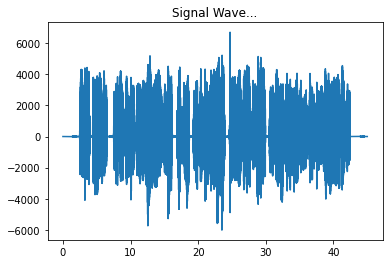

In [34]:
#@title Click RUN to show the wave form and play the voice.
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys


spf = wave.open("voice.wav", "r")

# Extract Raw Audio from Wav File
signal = spf.readframes(-1)
signal = np.fromstring(signal, "Int16")
fs = spf.getframerate()

# If Stereo
if spf.getnchannels() == 2:
    print("Just mono files")
    sys.exit(0)

Time = np.linspace(0, len(signal) / fs, num=len(signal))
plt.figure(1)
plt.title("Signal Wave...")
plt.plot(Time, signal)

plt.show()

ipd.Audio("voice.wav")

In [35]:
#@title Click RUN to download the vocal file.
files.download("voice.wav")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>